In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2025-12-17 23:11:45.466334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766013105.657488      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766013105.710857      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766013106.160426      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766013106.160494      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766013106.160497      24 computation_placer.cc:177] computation placer alr

In [3]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")

CSV file saved as dataset.csv


In [4]:
df.head()

image_path          category
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented

category
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


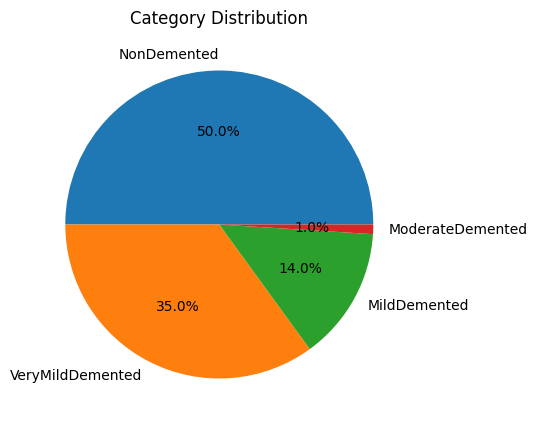

In [5]:
category_counts = df["category"].value_counts()
print(category_counts)

plt.figure(figsize=(12, 5))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()

In [6]:
def show_random_images(column, number_of_images_to_show=5, grey=False):
    categories = df["category"].unique()
    
    images_per_category = number_of_images_to_show
    
    plt.figure(figsize=(15, len(categories) * 5))
    for i, category in enumerate(categories):
        category_images = df[df["category"] == category][column].tolist()
        
        for j in range(min(len(category_images), images_per_category)):
            img_data = category_images[j]
            if column != "image_path":
                img = img_data
            else:
                img = cv2.imread(img_data)
                
            if column == "image_path":
                if grey:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(categories), images_per_category, i * images_per_category + j + 1)
            
            if grey:
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img)
            
            plt.axis("off")
            plt.title(f"{category}")
    
    plt.tight_layout()
    plt.show()

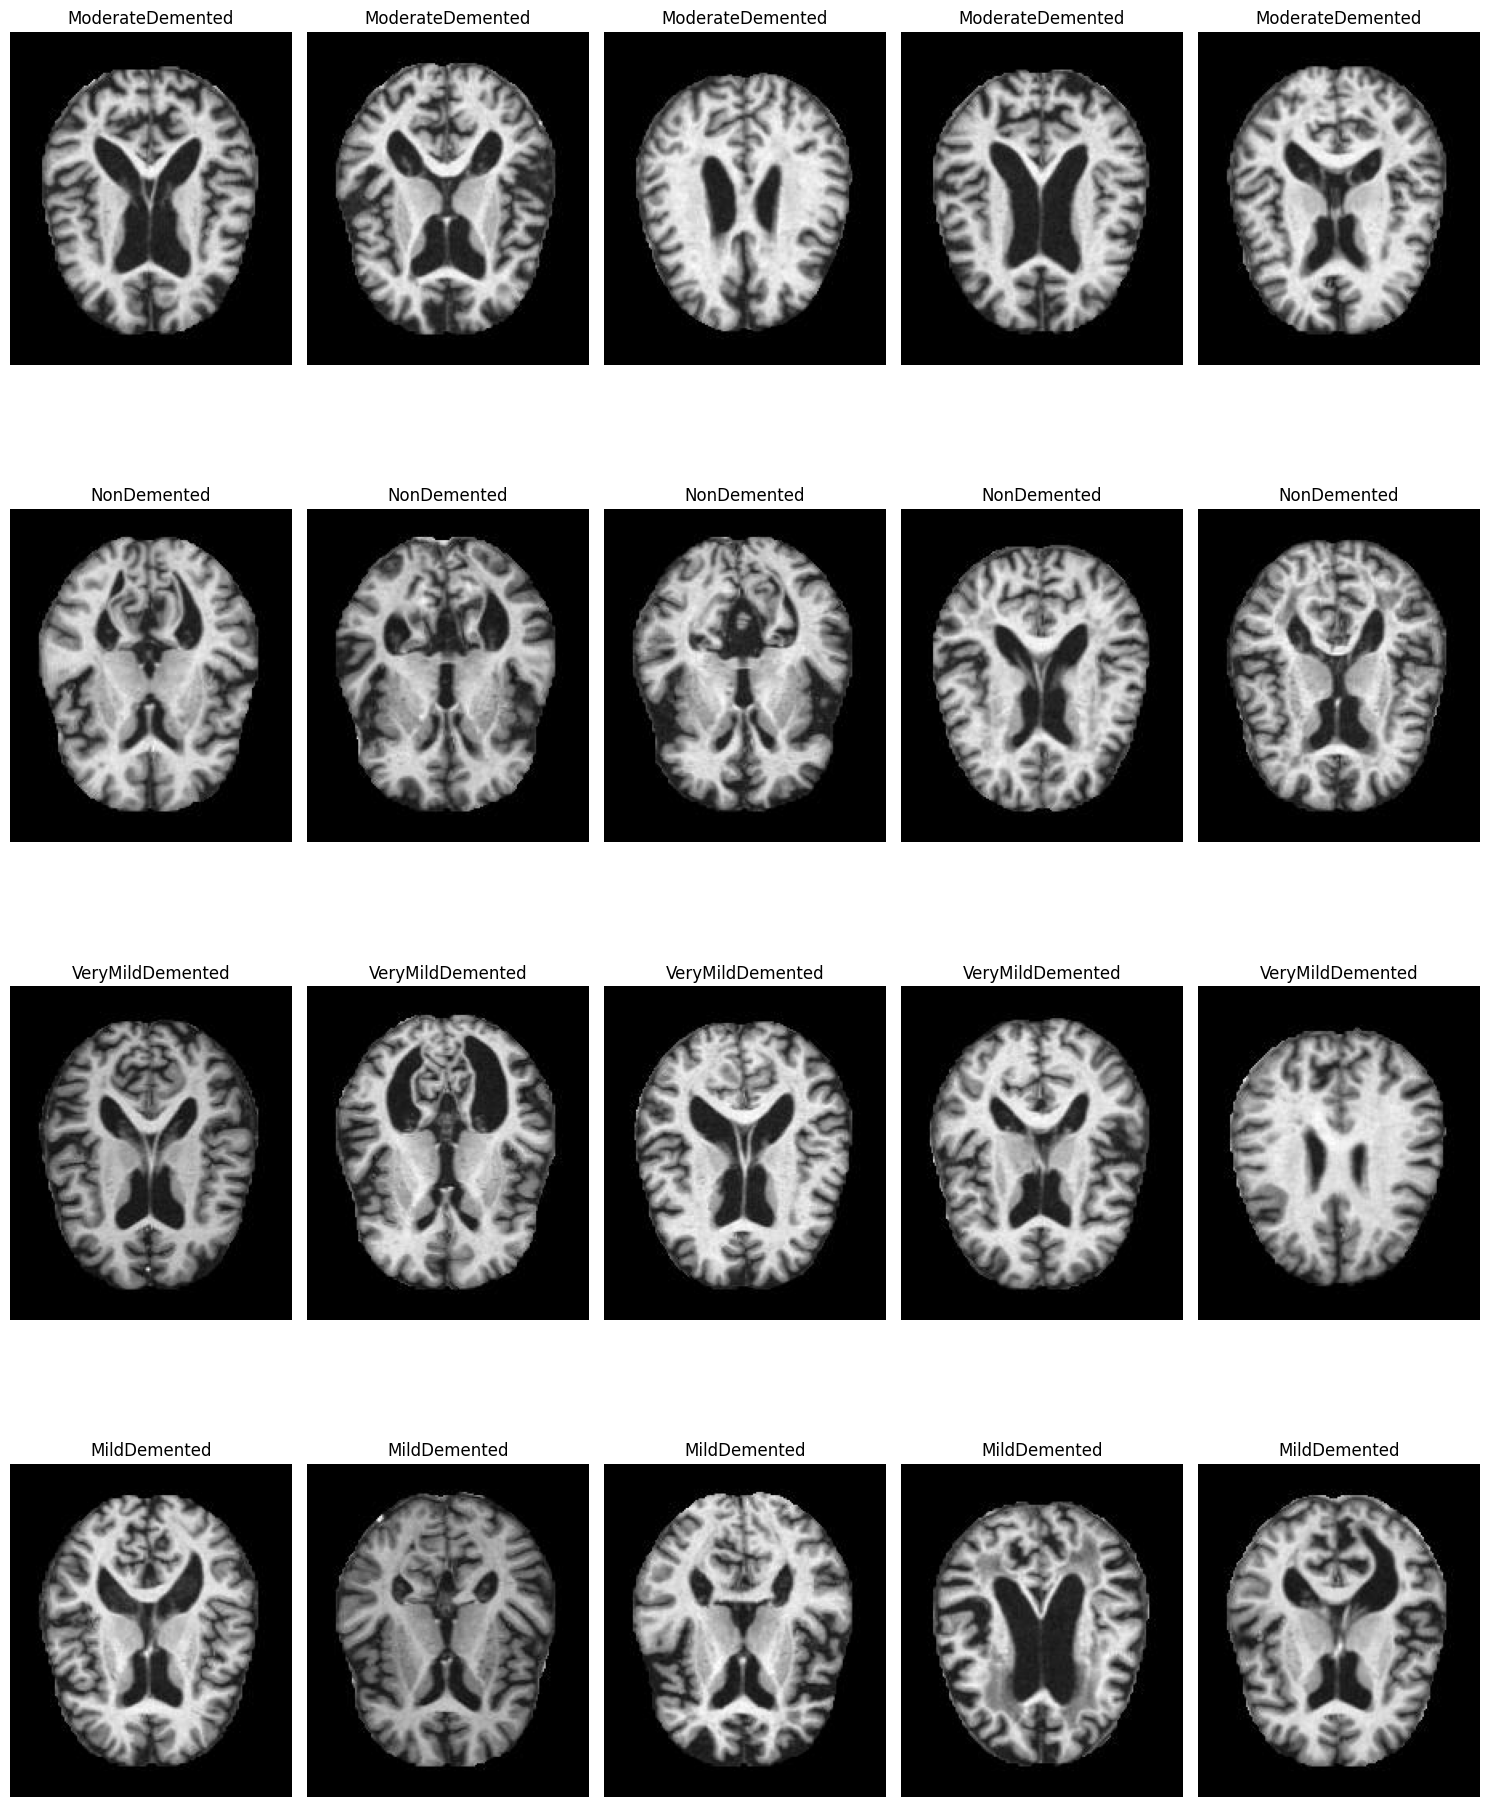

In [7]:
show_random_images("image_path", 5, False)

In [8]:
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

df['category'] = pd.Categorical(df['category'], categories=class_names, ordered=True)

df_encoded = pd.get_dummies(df['category'], dtype=int)
df_final = pd.concat([df, df_encoded], axis=1)
df_final = df_final.drop(columns=['category'])

# --- Sanity check: make sure we have the expected 4 classes ---
expected = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
print("✅ class_names (column order):", class_names)
missing = [c for c in expected if c not in class_names]
extra = [c for c in class_names if c not in expected]
if missing:
    print("⚠️ Missing expected classes:", missing)
if extra:
    print("⚠️ Unexpected extra classes:", extra)


✅ class_names (column order): ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']


In [9]:
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [10]:
oversampling_strategy = {
    'ModerateDemented': 4.0,
    'MildDemented': 2.5,
    'VeryMildDemented': 1.5,
    'NonDemented': 1
}

data_frames_to_concat = [train_df]

for class_name, multiplier in oversampling_strategy.items():
    
    if class_name in train_df.columns:
        print(f"Processing {class_name}: Adding {multiplier} amount...")
        
        class_rows = train_df[train_df[class_name] == 1]
        
        oversampled_rows = class_rows.sample(frac=multiplier, replace=True, random_state=42)
        
        data_frames_to_concat.append(oversampled_rows)

train_df_balanced = pd.concat(data_frames_to_concat, ignore_index=True)

train_df_balanced = train_df_balanced.sample(frac=1).reset_index(drop=True)

print("\n--- Before vs After Counts ---")
for col in oversampling_strategy.keys():

    old_count = train_df[col].sum()

    new_count = train_df_balanced[col].sum()

    print(f"{col}: {old_count} -> {new_count}")

Processing ModerateDemented: Adding 4.0 amount...
Processing MildDemented: Adding 2.5 amount...
Processing VeryMildDemented: Adding 1.5 amount...
Processing NonDemented: Adding 1 amount...

--- Before vs After Counts ---
ModerateDemented: 48 -> 240
MildDemented: 728 -> 2548
VeryMildDemented: 1811 -> 4527
NonDemented: 2533 -> 5066


In [11]:
rotation_layer = tf.keras.layers.RandomRotation(factor=0.02667) 
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.05, width_factor=0.05)

I0000 00:00:1766013120.462027      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
IMG_SIZE = 260

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    image = tf.expand_dims(image, 0) 
    image = rotation_layer(image)
    image = zoom_layer(image)
    image = image[0]
    
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02 * 255, dtype=tf.float32)
    image = tf.add(image, noise)

    image = tf.clip_by_value(image, 0.0, 255.0)
    
    return image, label

def apply_efficientnet_preprocess(image, label):
    image = preprocess_input(image)
    return image, label

In [13]:
def create_dataset(dataframe, batch_size=32, is_training=False):
    AUTOTUNE = tf.data.AUTOTUNE
    
    paths = dataframe['image_path'].values
    labels = dataframe[class_names].values
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    
    ds = ds.map(apply_efficientnet_preprocess, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.shuffle(buffer_size=1000)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [14]:
BATCH_SIZE = 8

print("Creating Training Dataset...")
train_ds = create_dataset(train_df_balanced, batch_size=BATCH_SIZE, is_training=True)

print("Creating Validation Dataset...")
val_ds = create_dataset(val_df, batch_size=BATCH_SIZE, is_training=False)

print("Creating Test Dataset...")
test_ds = create_dataset(test_df, batch_size=BATCH_SIZE, is_training=False)

print("All Datasets are ready.")

Creating Training Dataset...
Creating Validation Dataset...
Creating Test Dataset...
All Datasets are ready.


Visualizing Training Samples (with Augmentation)...


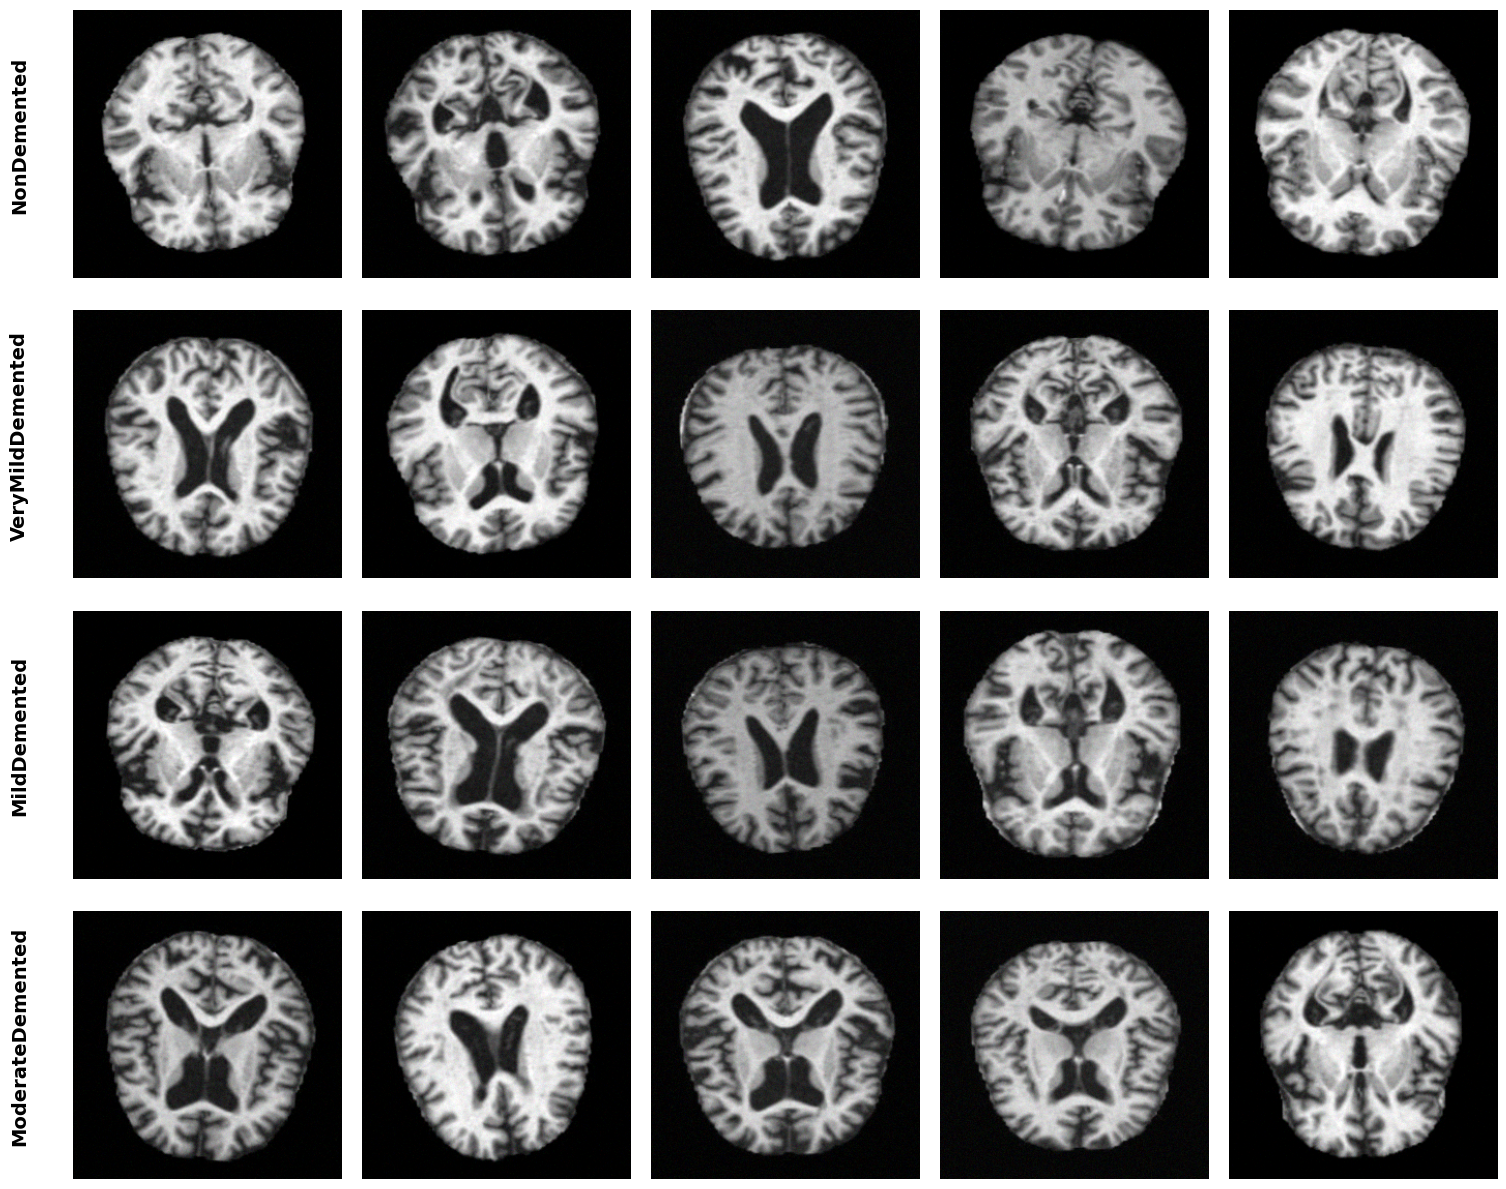

In [15]:
def visualize_samples_per_category(dataframe, class_names, samples_per_class=5):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 3 * num_classes))
    
    if num_classes == 1: axes = np.array([axes])
    if samples_per_class == 1: axes = np.expand_dims(axes, axis=1)

    for i, class_name in enumerate(class_names):
        class_samples = dataframe[dataframe[class_name] == 1].sample(samples_per_class)
        
        for j, (_, row) in enumerate(class_samples.iterrows()):
            image_path = row['image_path']
            
            img, _ = load_image(image_path, 0) 
            
            img, _ = augment_image(img, 0)
            
            img_to_show = img.numpy().astype("uint8")
            
            ax = axes[i, j]
            ax.imshow(img_to_show)
            ax.axis('off')
            
            if j == 0:
                ax.set_title(class_name, fontsize=14, fontweight='bold', x=-0.2, y=0.5, rotation=90, va='center')

    plt.tight_layout()
    plt.show()

print("Visualizing Training Samples (with Augmentation)...")
visualize_samples_per_category(train_df_balanced, class_names, samples_per_class=5)

In [16]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = False 

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, use_bias=False, activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Dense(128, use_bias=False, activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [18]:
train_labels_indices = np.argmax(train_df_balanced[class_names].values, axis=1)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_indices),
    y=train_labels_indices
)
class_weights_dict = dict(enumerate(class_weights_vals))

print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.6109849980260561), 1: np.float64(0.6837309476474487), 2: np.float64(1.214776295133438), 3: np.float64(12.896875)}


In [19]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    cooldown=1,
    min_lr=1e-6,
    verbose=1
)

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 1/100


I0000 00:00:1766013152.816912      70 service.cc:152] XLA service 0x415ee580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766013152.816956      70 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766013156.211296      70 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766013172.592034      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 157s 74ms/step - accuracy: 0.2515 - loss: 1.5760 - val_accuracy: 0.4422 - val_loss: 1.2278 - learning_rate: 1.0000e-04
Epoch 2/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 92s 55ms/step - accuracy: 0.4160 - loss: 1.1700 - val_accuracy: 0.4875 - val_loss: 1.1526 - learning_rate: 1.0000e-04
Epoch 3/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 92s 55ms/step - accuracy: 0.4520 - loss: 1.0465 - val_accuracy: 0.4469 - val_loss: 1.2530 - learning_rate: 1.0000e-04
Epoch 4/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 91s 55ms/step - accuracy: 0.4580 - loss: 1.0141 - val_accuracy: 0.4437 - val_loss: 1.2199 - learning_rate: 1.0000e-04
Epoch 5/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 91s 55ms/step - accuracy: 0.4831 - loss: 0.9522 - val_accuracy: 0.4750 - val_loss: 1.0911 - learning_rate: 1.0000e-04
Epoch 6/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 92s 55ms/step - accuracy: 0.4982 - loss: 0.8919 - val_accuracy: 0.4844 - val_loss: 1.0968 - learning_rate: 1.0000e-04
Epoch 7/100
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 91

In [21]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()

In [22]:
def evaluate_and_save_model(model, test_ds, test_df, threshold, class_names):
    
    target_names_ordered = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
    
    labels_indices = [class_names.index(name) for name in target_names_ordered]
    
    print("Generating predictions...")
    y_pred_probs = model.predict(test_ds, verbose=1)
    
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_max_probs = np.max(y_pred_probs, axis=1)
    
    not_sure_index = 4 
    
    y_pred_final = np.where(y_max_probs < threshold, not_sure_index, y_pred_classes)
    
    y_true = np.argmax(test_df[class_names].values, axis=1)
    
    extended_target_names = target_names_ordered + ['Not Sure']
    extended_labels_indices = labels_indices + [not_sure_index]
    
    cm = confusion_matrix(y_true, y_pred_final, labels=extended_labels_indices)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=extended_target_names,
                yticklabels=extended_target_names)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (With Uncertainty Threshold {threshold})')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred_final, 
        labels=extended_labels_indices,
        target_names=extended_target_names,
        zero_division=0
    ))


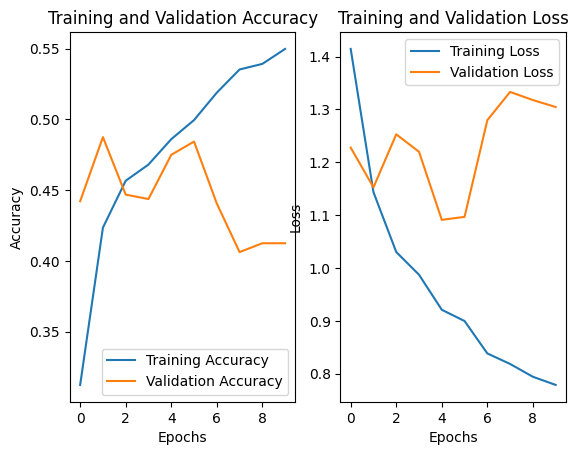

In [23]:
plot_training_history(history)

Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step


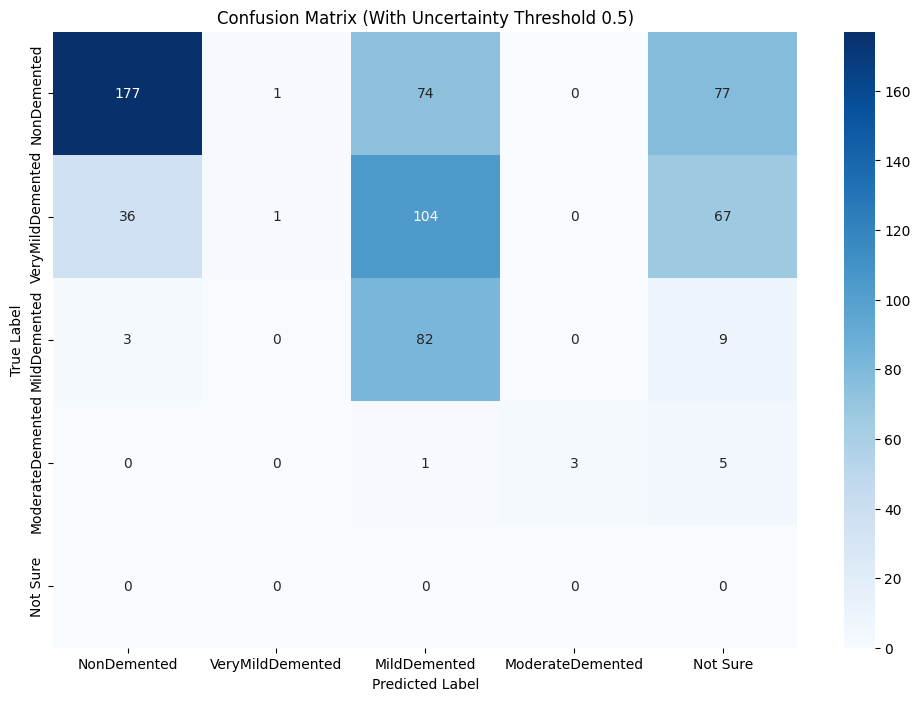


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.82      0.54      0.65       329
VeryMildDemented       0.50      0.00      0.01       208
    MildDemented       0.31      0.87      0.46        94
ModerateDemented       1.00      0.33      0.50         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.41       640
       macro avg       0.53      0.35      0.32       640
    weighted avg       0.64      0.41      0.41       640



In [24]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.5,
    class_names= class_names,
)


In [25]:
model.save("EfficientNetB2_Model_MultiClass_Frozen.h5")

In [26]:
base_model.trainable = True

for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = False
        
optimizer_fine = Adam(learning_rate=0.00001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer_fine,
              metrics=['accuracy'])

fine_tune_epochs = 100
total_epochs = 100 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 11/200


2025-12-17 23:29:38.350240: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 23:29:38.537560: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 23:29:38.995891: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 23:29:39.204731: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1547/1548 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5086 - loss: 0.8546

2025-12-17 23:32:33.244280: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 23:32:33.431527: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 23:32:33.865923: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 23:32:34.074743: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 262s 121ms/step - accuracy: 0.5086 - loss: 0.8545 - val_accuracy: 0.5500 - val_loss: 0.9781 - learning_rate: 1.0000e-05
Epoch 12/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 147s 90ms/step - accuracy: 0.5592 - loss: 0.7580 - val_accuracy: 0.5125 - val_loss: 1.1005 - learning_rate: 1.0000e-05
Epoch 13/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 147s 91ms/step - accuracy: 0.6103 - loss: 0.6872 - val_accuracy: 0.5875 - val_loss: 0.9899 - learning_rate: 1.0000e-05
Epoch 14/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 145s 90ms/step - accuracy: 0.6513 - loss: 0.6020 - val_accuracy: 0.6313 - val_loss: 0.8820 - learning_rate: 1.0000e-05
Epoch 15/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 147s 91ms/step - accuracy: 0.6908 - loss: 0.5427 - val_accuracy: 0.6203 - val_loss: 0.9641 - learning_rate: 1.0000e-05
Epoch 16/200
1548/1548 ━━━━━━━━━━━━━━━━━━━━ 144s 89ms/step - accuracy: 0.7270 - loss: 0.4884 - val_accuracy: 0.7281 - val_loss: 0.6342 - learning_rate: 1.0000e-05
Epoch 17/200
1548/1548 ━━━━━━━━━━━

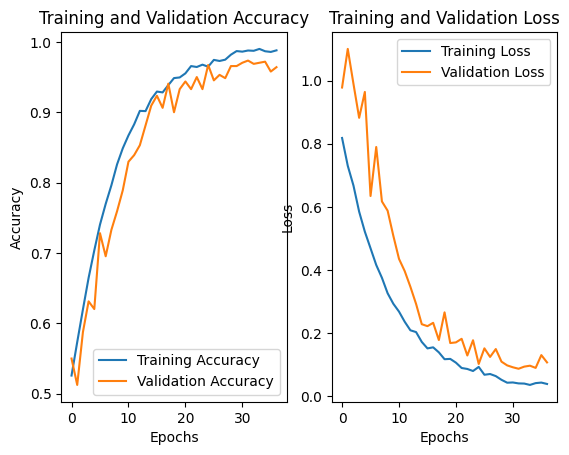

In [27]:
plot_training_history(history_fine)

Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step


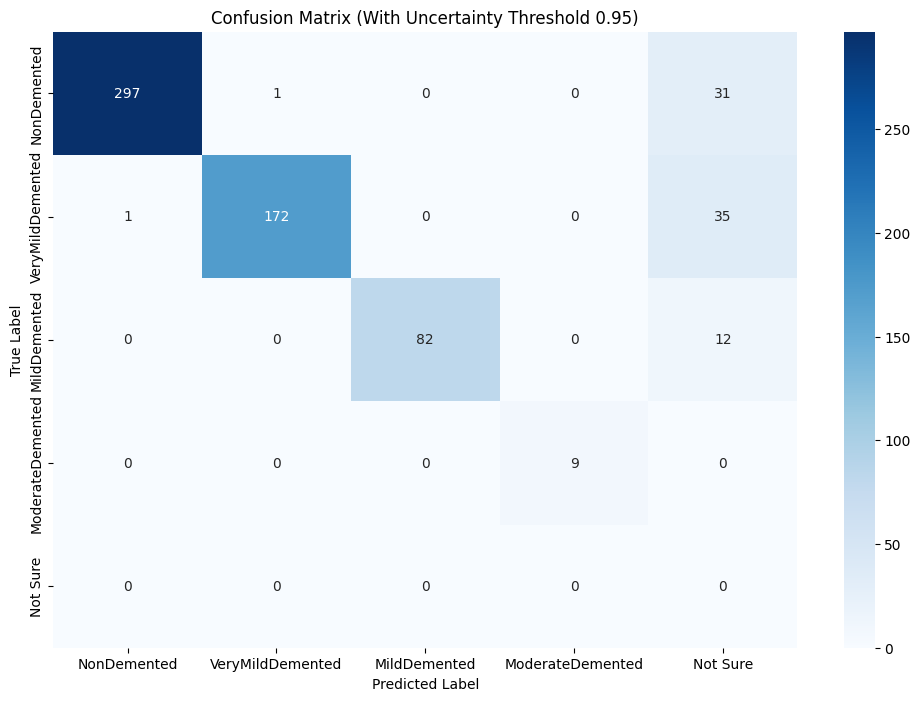


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       1.00      0.90      0.95       329
VeryMildDemented       0.99      0.83      0.90       208
    MildDemented       1.00      0.87      0.93        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.88       640
       macro avg       0.80      0.72      0.76       640
    weighted avg       1.00      0.88      0.93       640



In [28]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.95,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


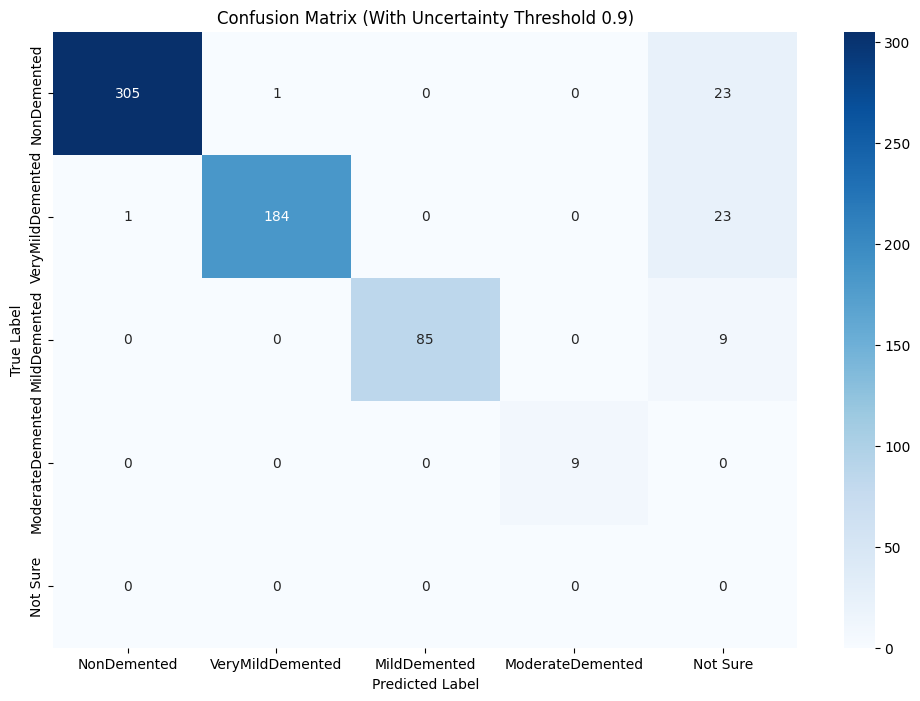


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       1.00      0.93      0.96       329
VeryMildDemented       0.99      0.88      0.94       208
    MildDemented       1.00      0.90      0.95        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.91       640
       macro avg       0.80      0.74      0.77       640
    weighted avg       1.00      0.91      0.95       640



In [29]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.9,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


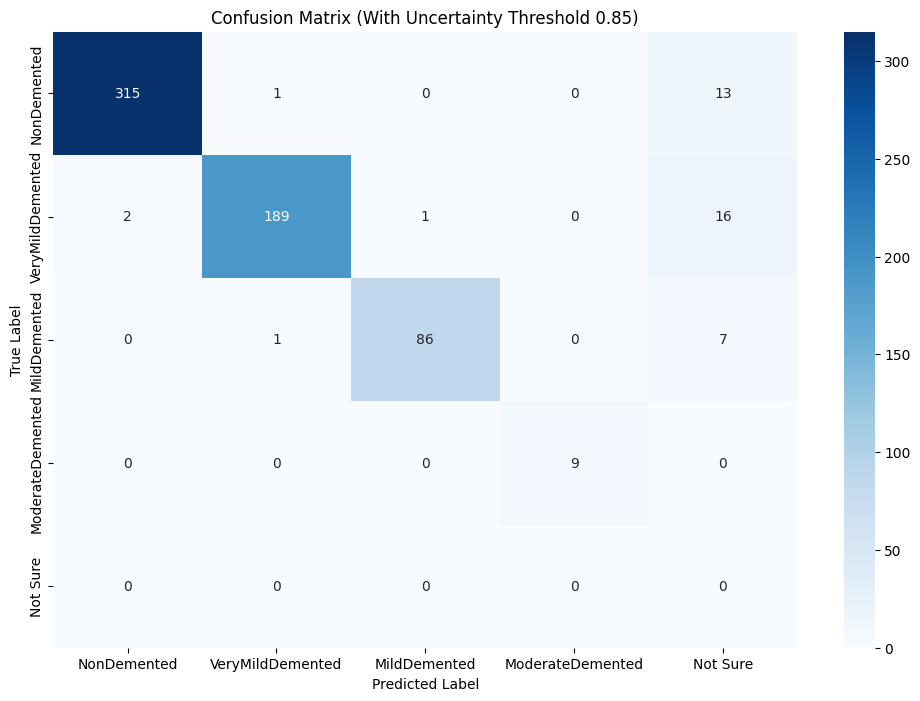


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.99      0.96      0.98       329
VeryMildDemented       0.99      0.91      0.95       208
    MildDemented       0.99      0.91      0.95        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.94       640
       macro avg       0.79      0.76      0.77       640
    weighted avg       0.99      0.94      0.96       640



In [30]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.85,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


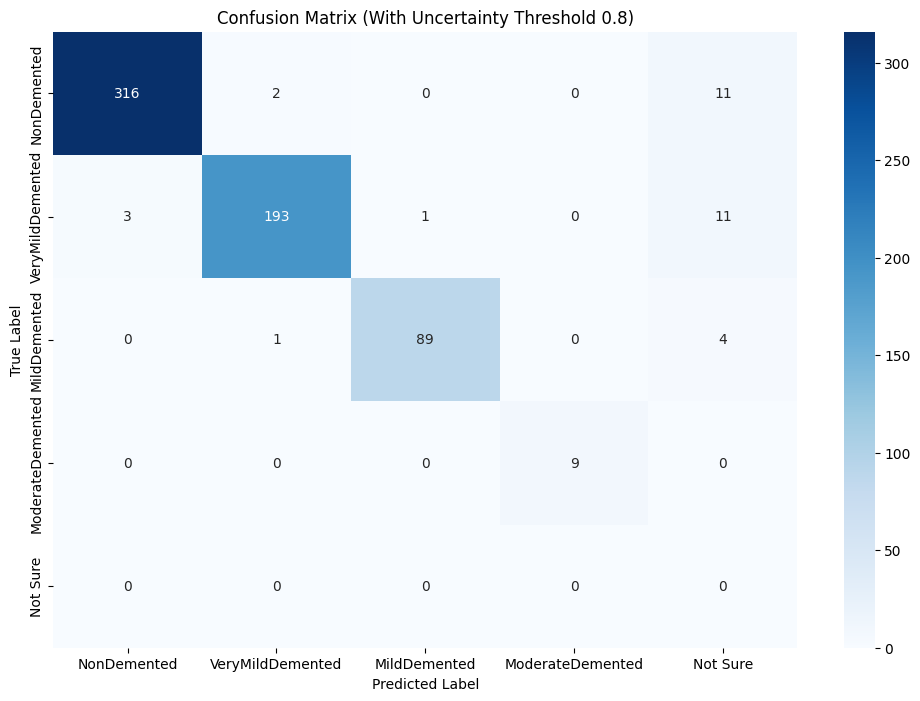


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.99      0.96      0.98       329
VeryMildDemented       0.98      0.93      0.96       208
    MildDemented       0.99      0.95      0.97        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.95       640
       macro avg       0.79      0.77      0.78       640
    weighted avg       0.99      0.95      0.97       640



In [31]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.8,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


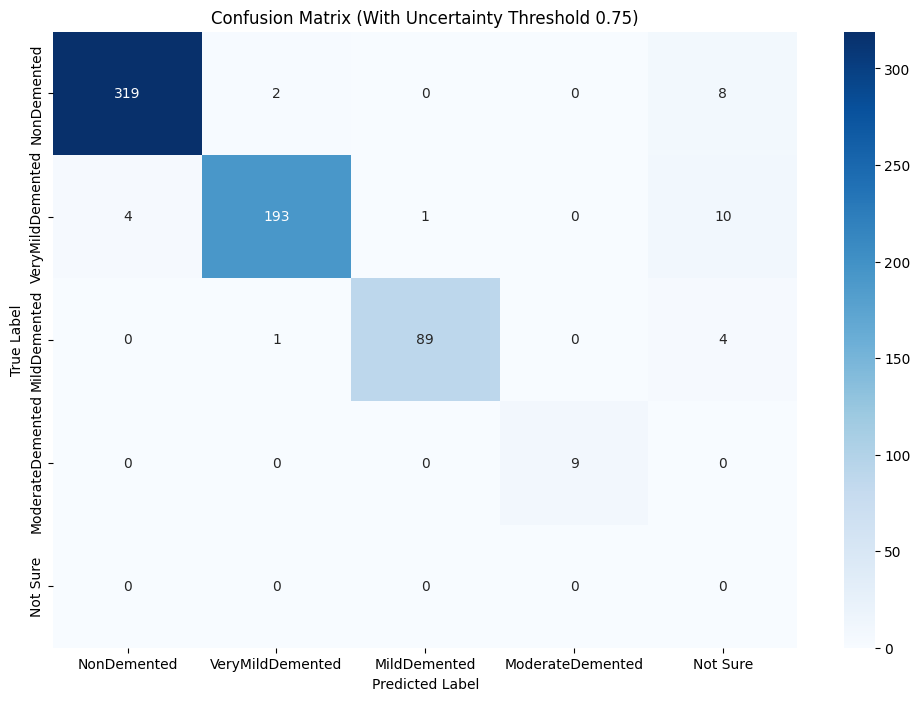


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.99      0.97      0.98       329
VeryMildDemented       0.98      0.93      0.96       208
    MildDemented       0.99      0.95      0.97        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.95       640
       macro avg       0.79      0.77      0.78       640
    weighted avg       0.99      0.95      0.97       640



In [32]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.75,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


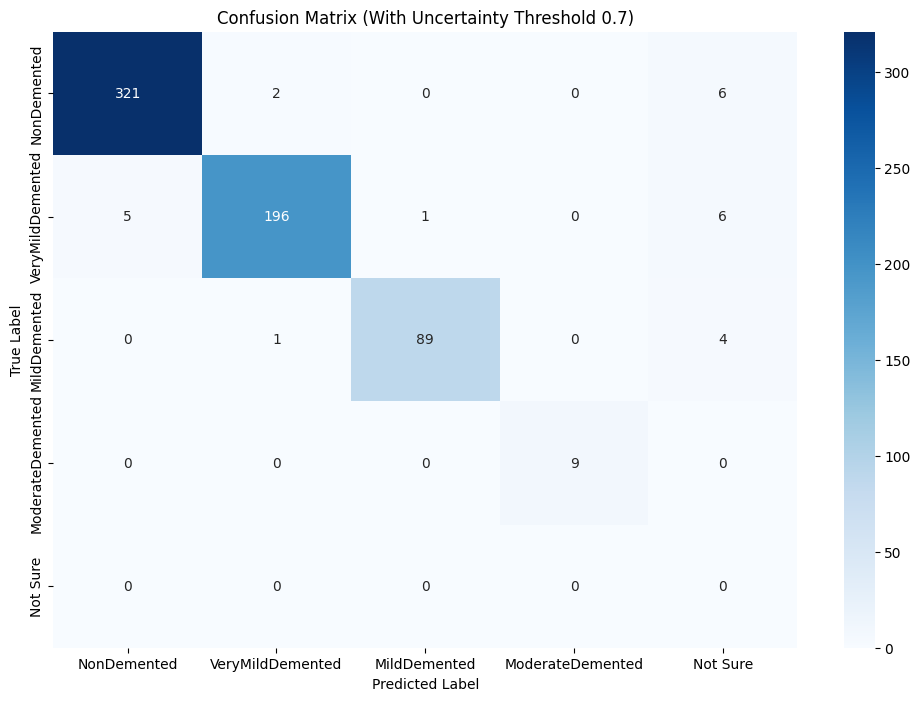


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.98      0.98      0.98       329
VeryMildDemented       0.98      0.94      0.96       208
    MildDemented       0.99      0.95      0.97        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.96       640
       macro avg       0.79      0.77      0.78       640
    weighted avg       0.99      0.96      0.97       640



In [33]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.7,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


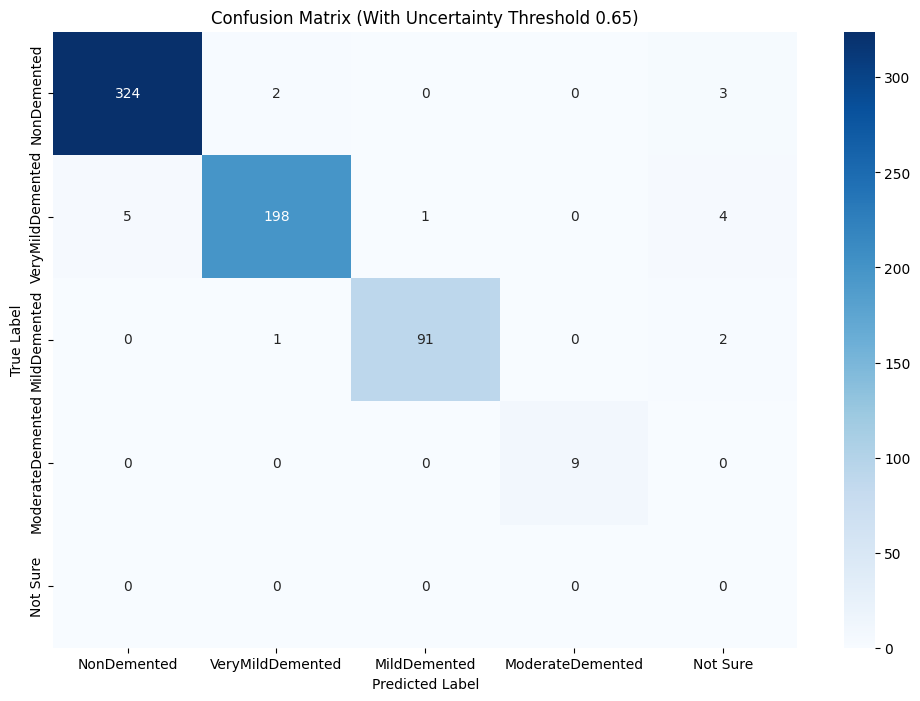


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.98      0.98      0.98       329
VeryMildDemented       0.99      0.95      0.97       208
    MildDemented       0.99      0.97      0.98        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.97       640
       macro avg       0.79      0.78      0.79       640
    weighted avg       0.99      0.97      0.98       640



In [34]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.65,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


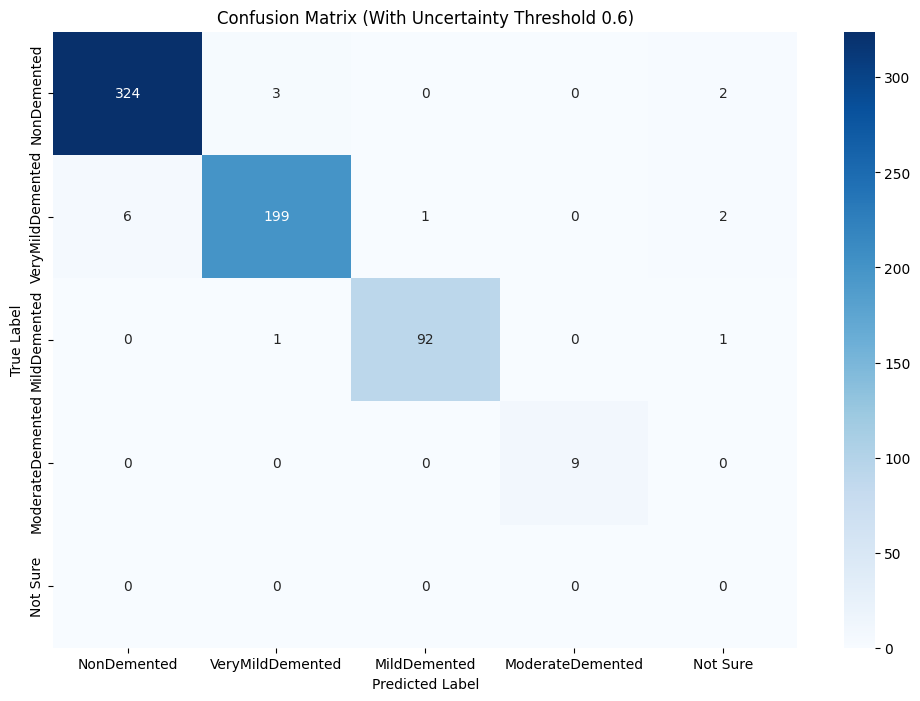


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.98      0.98      0.98       329
VeryMildDemented       0.98      0.96      0.97       208
    MildDemented       0.99      0.98      0.98        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.97       640
       macro avg       0.79      0.78      0.79       640
    weighted avg       0.98      0.97      0.98       640



In [35]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.6,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


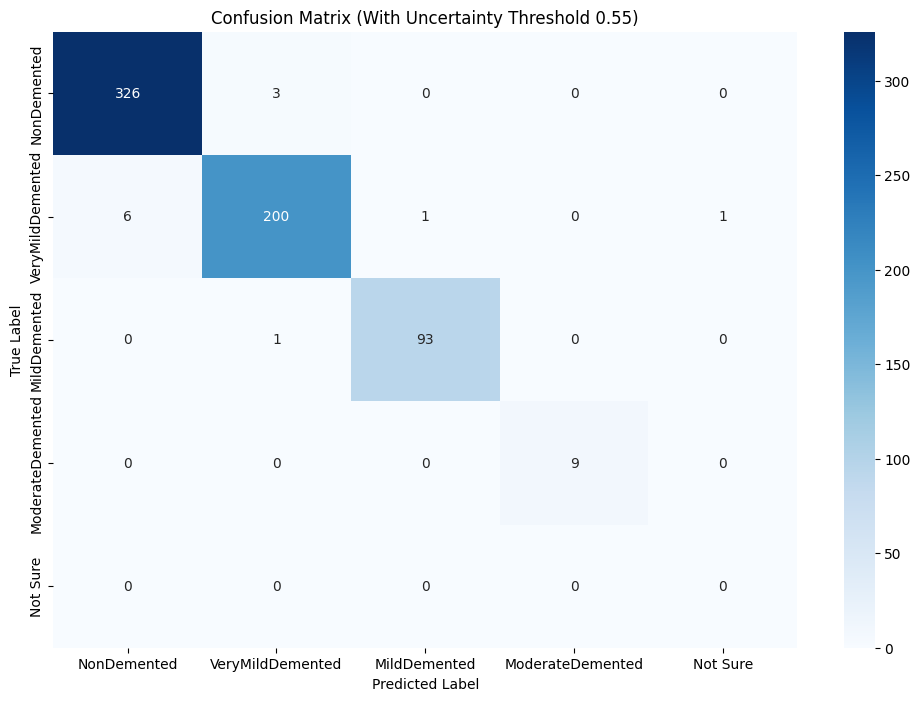


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.98      0.99      0.99       329
VeryMildDemented       0.98      0.96      0.97       208
    MildDemented       0.99      0.99      0.99        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.98       640
       macro avg       0.79      0.79      0.79       640
    weighted avg       0.98      0.98      0.98       640



In [36]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.55,
    class_names= class_names,
)


Generating predictions...
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


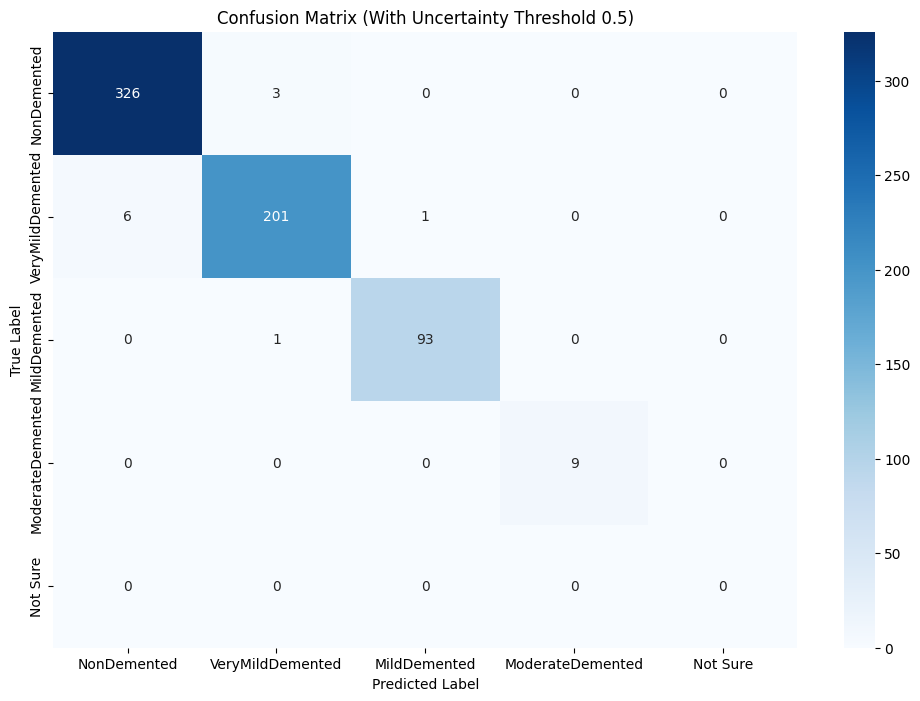


Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.98      0.99      0.99       329
VeryMildDemented       0.98      0.97      0.97       208
    MildDemented       0.99      0.99      0.99        94
ModerateDemented       1.00      1.00      1.00         9
        Not Sure       0.00      0.00      0.00         0

        accuracy                           0.98       640
       macro avg       0.79      0.79      0.79       640
    weighted avg       0.98      0.98      0.98       640



In [37]:
evaluate_and_save_model(
    model=model, 
    test_ds=test_ds, 
    test_df=test_df, 
    threshold = 0.5,
    class_names= class_names,
)


In [38]:
model.save("EfficientNetB2_Model_MultiClass_UnFrozen.h5")